# EV Driving Range Predicition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv("../Output/df_engineered.csv")
df.head()

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url,acceleration_efficiency,charging_speed_km_per_min,acceleration_class
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...,5.400000,7.158120,Moderate
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...,5.400000,7.494407,Moderate
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...,8.610169,8.333333,Fast
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...,8.193548,8.333333,Moderate
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5,8.000000,8.333333,Moderate


In [3]:
df.columns

Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url', 'acceleration_efficiency',
       'charging_speed_km_per_min', 'acceleration_class'],
      dtype='object')

In [4]:
selected_features = ['top_speed_kmh', 'battery_capacity_kWh', 'torque_nm', 'acceleration_0_100_s', 'drivetrain', 'segment', 'charging_speed_km_per_min']

## Scaling and Encoding of Data

In [5]:
X = df[selected_features]
y = df['range_km']

# One-hot encoding for categorical columns
X_encoded = pd.get_dummies(X, columns=['drivetrain', 'segment'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Scaling numeric features
scaler = StandardScaler()

# Identify numeric columns after encoding
numeric_cols = [
    'top_speed_kmh',
    'battery_capacity_kWh',
    'torque_nm',
    'acceleration_0_100_s',
    'charging_speed_km_per_min'
]

# Fit on train, transform both
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Print the shape of splits
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (380, 21)
Test shape: (96, 21)


In [6]:
X_train.head()

,top_speed_kmh,battery_capacity_kWh,torque_nm,acceleration_0_100_s,charging_speed_km_per_min,drivetrain_FWD,drivetrain_RWD,segment_B - Compact,segment_C - Medium,segment_D - Large,...,segment_F - Luxury,segment_G - Sports,segment_I - Luxury,segment_JA - Mini,segment_JB - Compact,segment_JC - Medium,segment_JD - Large,segment_JE - Executive,segment_JF - Luxury,segment_N - Passenger Van
208,-0.297106,-1.204418,-0.908106,0.621294,-1.317463,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
204,-0.000234,-1.349239,-0.908106,0.292119,-1.223452,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
429,-0.148670,0.147248,0.751319,-0.512531,0.203413,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
310,-0.445542,1.107896,-0.637773,0.987044,0.368023,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
22,-0.148670,0.147248,0.751319,-0.110206,-0.191653,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


## Model Training

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Bayesian Ridge': BayesianRidge(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(n_estimators=100, learning_rate=0.1, verbose=0, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

# Evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'R2 Score': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2)
    })

# Display results sorted by R2 Score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

print("Model Performance Summary:")
results_df

Model Performance Summary:


,Model,R2 Score,RMSE,MAE
0,XGBoost,0.9252,26.52,18.62
1,Gradient Boosting,0.9154,28.21,19.87
2,LightGBM,0.9146,28.34,20.34
3,Random Forest,0.9128,28.64,19.70
4,CatBoost,0.9078,29.44,20.83
5,Ridge Regression,0.8999,30.69,23.05
6,Bayesian Ridge,0.8993,30.77,23.10
7,Lasso Regression,0.8985,30.90,23.22
8,Linear Regression,0.8983,30.92,23.23
9,Decision Tree,0.8525,37.24,28.13


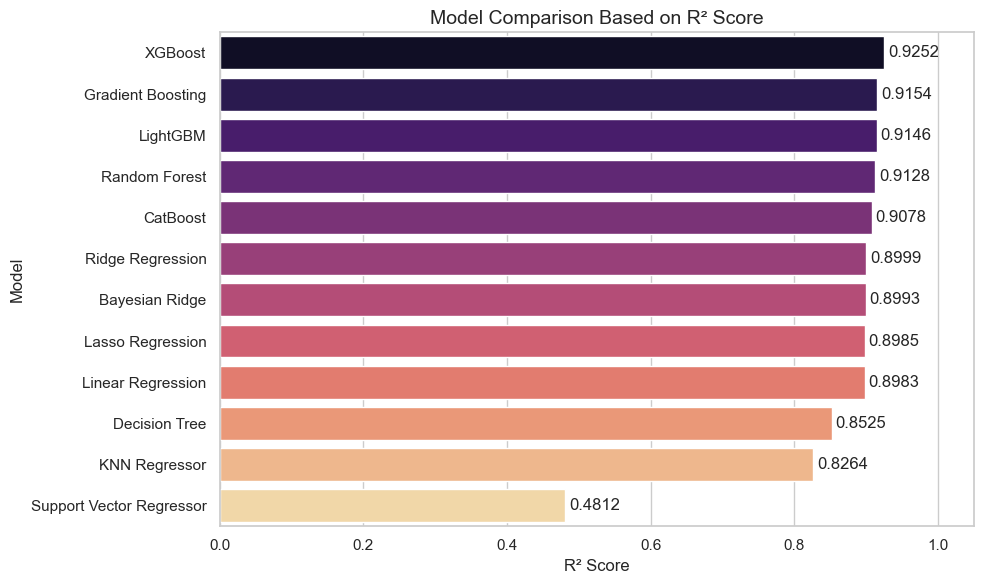

In [8]:
model_names = results_df['Model']
r2_scores = results_df['R2 Score']

sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
r2_plot = sns.barplot(
    data=results_df,
    x='R2 Score',
    y='Model',
    palette='magma'
)

# Add R² values as labels
for index, row in results_df.iterrows():
    plt.text(row['R2 Score'] + 0.005, index, f"{row['R2 Score']:.4f}", va='center')

# Title and labels
plt.title('Model Comparison Based on R² Score', fontsize=14)
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.xlim(0, 1.05)

plt.tight_layout()
plt.show()

### Feature Importance

In [9]:
rf_model = models['Random Forest']

# Get feature importances and corresponding feature names
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feat_imp_df.head()


,Feature,Importance
0,battery_capacity_kWh,0.789591
1,charging_speed_km_per_min,0.078425
2,top_speed_kmh,0.042334
3,segment_N - Passenger Van,0.022303
4,segment_F - Luxury,0.018550


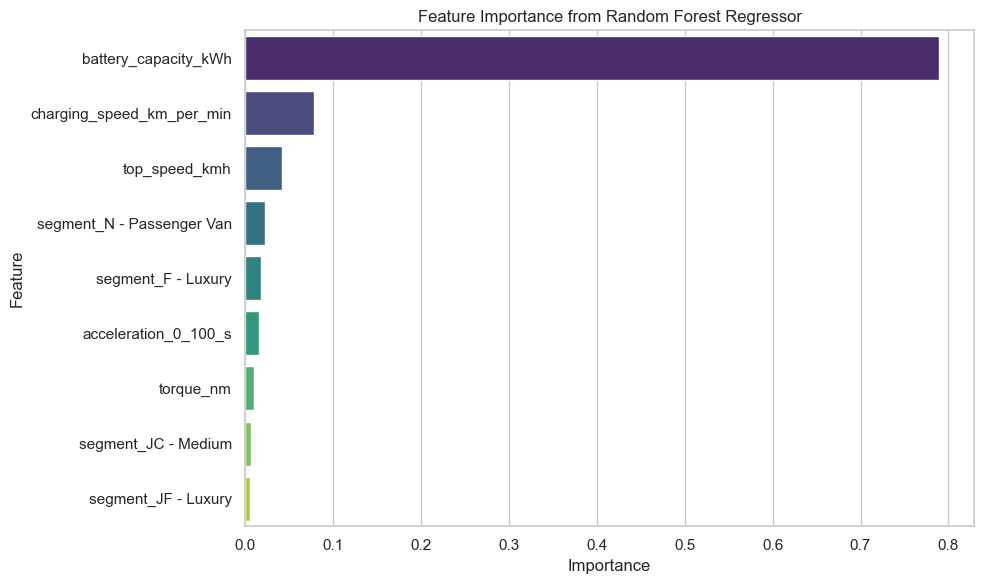

In [10]:
# Plot top 9 features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp_df.head(9),
    x='Importance',
    y='Feature',
    palette='viridis'
)

plt.title('Feature Importance from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Hyper-Parameter Tuning

In [11]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [12]:
from sklearn.model_selection import GridSearchCV

# Define models and their hyperparameter grids
param_grid = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
    },
    'Bayesian Ridge': {
        'model': BayesianRidge(),
        'params': {'alpha_1': [1e-6, 1e-5], 'alpha_2': [1e-6, 1e-5]}
    },
    'KNN Regressor': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'n_estimators': [50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, verbosity=0),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'depth': [3, 5]}
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2], 'kernel': ['rbf', 'linear']}
    }
}


In [13]:
best_models = {}
best_scores = []

for name, config in param_grid.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Save best estimator and its parameters
    best_models[name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_
    }

    best_scores.append({
        'Model': name,
        'Best R2 Score': round(grid_search.best_score_, 4),
        'Best Params': grid_search.best_params_
    })

# Create a summary DataFrame
best_models_df = pd.DataFrame(best_scores).sort_values(by='Best R2 Score', ascending=False).reset_index(drop=True)

print("✨ Hyperparameter Tuning Summary:")
print(best_models_df)


Tuning Linear Regression...
Tuning Ridge Regression...
Tuning Lasso Regression...
Tuning Bayesian Ridge...
Tuning KNN Regressor...
Tuning Decision Tree...
Tuning Random Forest...
Tuning Gradient Boosting...
Tuning XGBoost...
Tuning LightGBM...
Tuning CatBoost...
Tuning Support Vector Regressor...
✨ Hyperparameter Tuning Summary:
                       Model  Best R2 Score  \
0          Gradient Boosting         0.9460   
1                    XGBoost         0.9441   
2                   CatBoost         0.9405   
3              Random Forest         0.9307   
4   Support Vector Regressor         0.9257   
5           Ridge Regression         0.9252   
6           Lasso Regression         0.9251   
7             Bayesian Ridge         0.9250   
8          Linear Regression         0.9246   
9              KNN Regressor         0.9091   
10                  LightGBM         0.9072   
11             Decision Tree         0.8985   

                                          Best Params  
0

In [14]:
trained_models = {}

for name, details in best_models.items():
    print(f"Training final model for {name}...")

    # Get model with best params (already a fitted estimator, but you can re-train too)
    model = details['model']

    # Optional: Retrain (recommended if you used only part of data during GridSearch)
    model.fit(X_train, y_train)

    # Save trained model
    trained_models[name] = model


Training final model for Linear Regression...
Training final model for Ridge Regression...
Training final model for Lasso Regression...
Training final model for Bayesian Ridge...
Training final model for KNN Regressor...
Training final model for Decision Tree...
Training final model for Random Forest...
Training final model for Gradient Boosting...
Training final model for XGBoost...
Training final model for LightGBM...
Training final model for CatBoost...
Training final model for Support Vector Regressor...


In [15]:
evaluation_results = {}

print("\nFinal Evaluation on Test Set:")
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print the results
    print(f"{name}: R² = {r2:.4f}, MAE = {mae:.4f}")

    # Store results in dictionary
    evaluation_results[name] = {
        'R2': round(r2, 4),
        'MAE': round(mae, 4)
    }

# Convert to DataFrame for easy analysis and plotting
eval_df = pd.DataFrame.from_dict(evaluation_results, orient='index').reset_index()
eval_df.columns = ['Model', 'R2 Score', 'MAE']


Final Evaluation on Test Set:
Linear Regression: R² = 0.8983, MAE = 23.2267
Ridge Regression: R² = 0.8999, MAE = 23.0468
Lasso Regression: R² = 0.9000, MAE = 23.1564
Bayesian Ridge: R² = 0.8993, MAE = 23.1035
KNN Regressor: R² = 0.8487, MAE = 25.2861
Decision Tree: R² = 0.8560, MAE = 25.3851
Random Forest: R² = 0.9128, MAE = 19.6996
Gradient Boosting: R² = 0.9223, MAE = 18.3074
XGBoost: R² = 0.9258, MAE = 17.9982
LightGBM: R² = 0.9137, MAE = 19.9921
CatBoost: R² = 0.9209, MAE = 18.3418
Support Vector Regressor: R² = 0.8905, MAE = 23.2513


In [16]:
eval_df

,Model,R2 Score,MAE
0,Linear Regression,0.8983,23.2267
1,Ridge Regression,0.8999,23.0468
2,Lasso Regression,0.9000,23.1564
3,Bayesian Ridge,0.8993,23.1035
4,KNN Regressor,0.8487,25.2861
5,Decision Tree,0.8560,25.3851
6,Random Forest,0.9128,19.6996
7,Gradient Boosting,0.9223,18.3074
8,XGBoost,0.9258,17.9982
9,LightGBM,0.9137,19.9921


In [17]:
eval_df.to_csv("../Output/final_evaluation_results.csv", index=False)

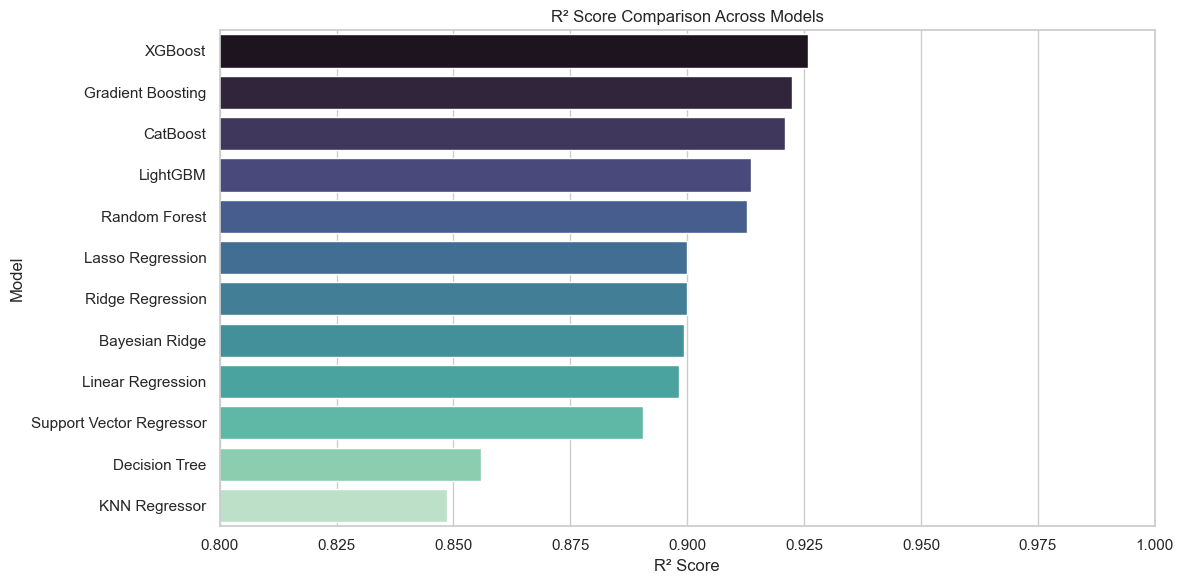

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=eval_df.sort_values('R2 Score', ascending=False), x='R2 Score', y='Model', palette='mako')
plt.title("R² Score Comparison Across Models")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.xlim(0.8, 1)
plt.tight_layout()
plt.show()

## Top 3 Performing Models

1. **🥇 XGBoost Regressor**  
   - **R²** = 0.9258  
   - **MAE** = 17.9982  
   - Delivers the highest prediction accuracy and lowest mean error.

2. **🥈 Gradient Boosting Regressor**  
   - **R²** = 0.9223  
   - **MAE** = 18.3074  
   - Strong generalization with minimal overfitting.

3. **🥉 CatBoost Regressor**  
   - **R²** = 0.9209  
   - **MAE** = 18.3418  
   - Very effective, especially for categorical data.

---

## Insights

- **Ensemble methods** (XGBoost, CatBoost, Gradient Boosting, Random Forest, LightGBM) significantly outperform **linear and non-parametric models** in both accuracy and error metrics.
- Models like **KNN** and **Decision Tree** are less suitable for this regression task due to higher MAE and lower R².
- **Linear models** (Linear, Ridge, Lasso, Bayesian Ridge) still perform fairly well, and are useful when interpretability is preferred.
